In [1]:
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import sampler
import torchvision
import torchvision.transforms as T
from PIL import Image
from matplotlib.image import imread
from tqdm import tqdm
import random
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar  8 22:31:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    53W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#x transform
vgg_transform = T.Compose([  
 T.ToTensor(),             #[1]
 T.Resize(256),                    #[2]
 T.CenterCrop(224),                #[3]                    #[4]
 T.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])
#y_transform
vgg_y_transform = T.Compose([
    T.ToTensor(),
    T.Resize(256, interpolation=T.InterpolationMode.NEAREST),
    T.CenterCrop(224)
])

In [5]:
#make lists of names of train and val sets
train_images = open('/content/drive/MyDrive/train.txt')
train_data = train_images.read()

train_into_list = train_data.split("\n")[:-1]
train_images.close()

val_images = open('/content/drive/MyDrive/val.txt')
val_data = val_images.read()

val_into_list = val_data.split("\n")[:-1]
val_images.close()

In [6]:
from torchvision.models import vgg16

In [7]:
#instantiate pretrained vgg16
vgg16full = vgg16(weights=torchvision.models.VGG16_Weights)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [8]:
new_model = nn.Sequential(*list(vgg16full.children())[0])
new_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [9]:
vgg16layers = list(new_model)
vgg16layers

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [10]:
#construct convolutional layers of vgg16
class VGG16(nn.Module):
  def __init__(self):
    super(VGG16, self).__init__()
    self.conv1 = vgg16layers[0] # 3 -> 64
    self.conv2 = vgg16layers[2] # 64 -> 64
    self.conv3 = vgg16layers[5] # 64 -> 128
    self.conv4 = vgg16layers[7] # 128 -> 128
    self.conv5 = vgg16layers[10] # 128 -> 256
    self.conv6 = vgg16layers[12] # 256 -> 256
    self.conv7 = vgg16layers[14] # 256 -> 256
    self.conv8 = vgg16layers[17] # 256 -> 512
    self.conv9 = vgg16layers[19] # 512 -> 512
    self.conv10 = vgg16layers[21] # 512 -> 512
    self.conv11 = vgg16layers[24] # 512 -> 512
    self.conv12 = vgg16layers[26] # 512 -> 512
    self.conv13 = vgg16layers[28] # 512 -> 512
    self.max_pool = vgg16layers[4]
    self.relu = vgg16layers[1]

  def forward(self, x):
    s = x
    x = self.relu(self.conv2(self.relu(self.conv1(x))))
    a = x
    x = self.max_pool(x)
    x = self.relu(self.conv4(self.relu(self.conv3(x))))
    b = x
    x = self.max_pool(x)
    x = self.relu(self.conv7(self.relu(self.conv6(self.relu(self.conv5(x))))))
    c = x
    x = self.max_pool(x)
    x = self.relu(self.conv10(self.relu(self.conv9(self.relu(self.conv8(x))))))
    d = x
    x = self.max_pool(x)
    x = self.relu(self.conv13(self.relu(self.conv12(self.relu(self.conv11(x))))))
    e = x
    x = self.max_pool(x)

    return s, a, b, c, d, e, x


In [11]:
#construct shallow model with fully connected layers
class ShallowModel(nn.Module):
  def __init__(self):
    super(ShallowModel, self).__init__()
    self.fc1 = nn.Linear(1475, 3000)
    self.fc2 = nn.Linear(3000, 1000)
    self.fc3 = nn.Linear(1000, 300)
    self.fc4 = nn.Linear(300, 100)
    self.fc5 = nn.Linear(100, 21)
    self.dropout1 = nn.Dropout(0.5)


  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.fc5(x)


    return x

In [12]:
#returns concatenated activations from convolutional layers of VGG
def create_hypercolumns(s, a, b, c, d, e):
  u = nn.Upsample(size = 224, mode='bilinear')
  ua = u(a)
  ub = u(b)
  uc = u(c)
  ud = u(d)
  ue = u(e)
  return torch.cat((s, ua, ub, uc, ud, ue), axis=1)



In [13]:
#return locations sampled from image at which to construct hypercolumns
#sample locations from 6 pixels per class
def sample_points(seg_image):
  sampled_indices = [[0,0]]
  for value in np.unique(seg_image)[:-1]: #leave out 255 (ambiguous) values
    indices = np.argwhere(seg_image == value)
    sampled_indices.extend(indices[np.random.choice(indices.shape[0], 6, replace=True), :])

  return sampled_indices[1:]



In [14]:
#construct hypercolumn dataset by sampling from each image
#iterate over images, compute hypercolumns, sample points
#then select hypercolumns and labels at those points
def contstruct_hypercolumn_dataset(lst, model):
  count = 1
  xs = np.zeros((1, 1475))
  ys = np.array([0])
  model.to('cuda')
  model.eval()
  for i in lst:
    x_path = '/content/drive/MyDrive/train_x/' + i + '.jpg'
    y_path = '/content/drive/MyDrive/train_y/' + i + '.png'
    image = np.array(Image.open(x_path))
    image = vgg_transform(image)
    image = torch.unsqueeze(image, 0)
    image = image.to('cuda')
    classes = np.array(Image.open(y_path))
    classes = vgg_y_transform(classes)

    

    s, a, b, c, d, e, _ = model(image)
    hypercolumns = create_hypercolumns(s, a, b, c, d, e)
    classes = np.rint(classes.detach().numpy()[0]*255)
    indices = sample_points(classes)

    hypercolumns = hypercolumns.to('cpu')
    hypercolumns = hypercolumns.detach().numpy()

    for id in indices:
      r = id[0]
      c = id[1]
      column = hypercolumns[0, :, r, c]
      label = classes[r, c]
      xs = np.vstack((xs, column))
      ys = np.append(ys, int(label))

    if count % 50 == 0:
      print('images processed:', count)
      print(xs[-1], ys[-1])
      print(len(xs), len(ys))
    count += 1

  print(len(xs), len(ys))

  return xs, ys






In [15]:
#make and save hypercolumn dataset
#model = VGG16()
#xs, ys = contstruct_hypercolumn_dataset(train_into_list, model)

In [16]:
#np.save('/content/drive/MyDrive/bighypercolumnarray16.npy', xs)
#np.save('/content/drive/MyDrive/bighypercolumnlabels16.npy', ys)

In [17]:
#put trainset into dataloader
x_train = np.load('/content/drive/MyDrive/bighypercolumnarray16.npy')
y_train = np.load('/content/drive/MyDrive/bighypercolumnlabels16.npy')
x_tensor = torch.from_numpy(x_train).float()
y_tensor = torch.from_numpy(y_train)
trainset = TensorDataset(x_tensor, y_tensor)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

In [18]:
def train(loader_train, conv_model, shallow_model, optimizer, scheduler, epochs=100):
  shallow_model.to('cuda')
  conv_model.to('cuda')
  criterion = nn.CrossEntropyLoss()
  
  #instantiate variables
  training_losses = np.array([4])
  best_classavg_prec = 1/21
  best_acc = 1/21
  best_classavg_acc = 1/21
  accs = np.array([1/21])
  class_precs = np.array([[1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21,
                          1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21,
                          1/21, 1/21, 1/21]])
  class_accs = np.array([[1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21,
                          1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21,
                          1/21, 1/21, 1/21]])
  class_avg_precs = np.array([1/21]) 
  class_avg_accs = np.array([1/21])

  for e in range(epochs):
    shallow_model.train()
    for t, (x, y) in enumerate(loader_train):
      
      #forward and backwards passes
      inputs, labels = (x, y)
      inputs = inputs.to('cuda')
      labels = labels.to('cuda')

      optimizer.zero_grad()

      outputs = shallow_model(inputs)
      loss = criterion(outputs, labels)
                
      loss.backward()
      optimizer.step()

      if t % 20 == 0:
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
        training_losses = np.append(training_losses, loss.item())

    scheduler.step()

    #test and append measurements
    acc, classaccs , classaccsavg, classprecs, classprecavg = test(val_into_list, conv_model, shallow_model)
    accs = np.append(accs, acc)
    class_accs = np.vstack((class_accs, classaccs))
    class_avg_accs = np.append(class_avg_accs, classaccsavg)
    class_precs = np.vstack((class_precs, classprecs))
    class_avg_precs = np.append(class_avg_precs, classprecavg)
    

    #check for best models
    if acc > best_acc:
      best_acc = acc
      best_acc_model = shallow_model
      
    if classaccsavg > best_classavg_acc:
      best_classavg_acc = classaccsavg
      best_classavg_model = shallow_model
    if classprecavg > best_classavg_prec:
      best_classavg_prec = classprecavg
      best_precavg_model = shallow_model
  
  torch.save(best_acc_model, '/content/drive/MyDrive/best_acc_model.pt')
  model1 = torch.load('/content/drive/MyDrive/best_acc_model.pt')
  model1.eval()
  torch.save(best_classavg_model, '/content/drive/MyDrive/best_classavg_model.pt')
  model2 = torch.load('/content/drive/MyDrive/best_classavg_model.pt')
  model2.eval()
  torch.save(best_precavg_model, '/content/drive/MyDrive/best_precavg_model.pt')
  model3 = torch.load('/content/drive/MyDrive/best_precavg_model.pt')
  model3.eval()


  
  return accs, class_avg_accs, class_accs, class_avg_precs, class_precs, best_acc, best_classavg_acc, best_classavg_prec, training_losses


    

In [19]:
#compute true positives, false positives, and false negatives on a single test image
def compute_acc_single(label, preds):
  correct_counts = torch.zeros(21)
  total_counts = torch.zeros(21)
  true_pos = torch.zeros(21)
  total_pos = torch.zeros(21)

  for i in range(21):
    #accuracy
    correct_counts[i] = torch.sum((preds == i) & (label == i))
    total_counts[i] = torch.sum(label == i)

    #precision
    total_pos[i] = torch.sum(preds==i)


  num_correct = (preds == label).sum().item()
  num_samples = 224*224

  ambigs = label.unique(return_counts=True)[0][-1] #subtract out 255s
  num_samples -= ambigs

  return num_correct, num_samples, correct_counts, total_counts, total_pos



In [20]:
def test(lst, conv_model, shallow_model):
  best_acc = 0
  num_correct = 0
  num_samples = 0
  correct_array = torch.zeros(21)
  total_posactual = torch.zeros(21)
  total_pospreds = torch.zeros(21)
  conv_model = conv_model.cuda()
  shallow_model = shallow_model.cuda()
  conv_model.eval()
  shallow_model.eval()
  #rand_indices = [random.randint(0, 1448) for i in range(50)]
  with torch.no_grad():
    #for im in tqdm(list(lst[i] for i in rand_indices)):
    for im in tqdm(lst):
      x_path = '/content/drive/MyDrive/val_x/' + im + '.jpg'
      y_path = '/content/drive/MyDrive/val_y/' + im + '.png'

      #read images, transform, compute hypercolumns, flatten x to 2d, flatten y to vector
      x = np.array(Image.open(x_path))
      x = vgg_transform(x)
      x = torch.unsqueeze(x, 0)
      x = x.to('cuda')
      y = np.array(Image.open(y_path))
      y = vgg_y_transform(y)
      y = torch.round(y[0]*255)
      s, a, b, c, d, e, _ = conv_model(x)
      hypercolumns = create_hypercolumns(s, a, b, c, d, e)
      
      hypers_flattened = hypercolumns.view(1475, -1).t()
      hypers_flattened = hypers_flattened.to('cuda')
      y = torch.flatten(y)
      y = y.to('cuda')
      


      #pass x through shallow model and get predictions
      pred_dist = shallow_model(hypers_flattened)
      preds = torch.argmax(pred_dist, dim=1)

      #compute single image accuracy
      im_correct, im_samples, im_correct_classes, im_counts_classes, im_pospreds = compute_acc_single(y, preds)

      #update total accuracies and precisions
      num_correct += im_correct
      num_samples += im_samples
      correct_array += im_correct_classes
      total_posactual += im_counts_classes
      total_pospreds += im_pospreds


    acc = num_correct / num_samples
    class_precisions = torch.nan_to_num(correct_array/total_pospreds)
    class_precisions_avg = torch.mean(class_precisions)
    class_accs = torch.nan_to_num(correct_array/total_posactual)
    class_accs_avg = torch.mean(class_accs)
    print('Accuracy:', float(acc))
    print('Accuracy by class:', class_accs)
    print('Mean class accuracy:', class_accs_avg)
    print('Precision by class:', class_precisions)
    print('Mean class precision:', class_precisions_avg)
    return float(acc), class_accs.detach().numpy(), float(class_accs_avg), class_precisions.detach().numpy(), float(class_precisions_avg)

In [21]:
vgg_model = VGG16()
shallow_classifier = ShallowModel()
optimizer = optim.SGD(shallow_classifier.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0)
scheduler = MultiStepLR(optimizer, milestones=[6,12], gamma=0.1)
accs, class_avg_accs, class_accs, class_avg_precs, class_precs, best_acc, best_classavg_acc, best_classavg_prec, training_losses = train(trainloader, vgg_model, shallow_classifier, optimizer, scheduler, epochs=15)

Epoch 0, Iteration 0, loss = 3.0358
Epoch 0, Iteration 20, loss = 2.7941
Epoch 0, Iteration 40, loss = 2.4242
Epoch 0, Iteration 60, loss = 1.9045
Epoch 0, Iteration 80, loss = 1.8445
Epoch 0, Iteration 100, loss = 2.0409
Epoch 0, Iteration 120, loss = 1.8524
Epoch 0, Iteration 140, loss = 2.1244
Epoch 0, Iteration 160, loss = 1.9040
Epoch 0, Iteration 180, loss = 1.7656
Epoch 0, Iteration 200, loss = 1.5550
Epoch 0, Iteration 220, loss = 1.2784
Epoch 0, Iteration 240, loss = 1.4911
Epoch 0, Iteration 260, loss = 1.5447
Epoch 0, Iteration 280, loss = 1.5266
Epoch 0, Iteration 300, loss = 1.6239
Epoch 0, Iteration 320, loss = 1.8868


100%|██████████| 1449/1449 [18:53<00:00,  1.28it/s]


Accuracy: 0.6677852272987366
Accuracy by class: tensor([9.3205e-01, 4.1567e-01, 2.6299e-01, 1.2261e-01, 0.0000e+00, 6.1015e-02,
        1.3922e-01, 3.4072e-01, 6.9889e-01, 5.3746e-03, 2.6760e-01, 0.0000e+00,
        9.3737e-02, 2.5857e-01, 2.7554e-01, 7.7555e-01, 2.0298e-02, 3.2513e-03,
        0.0000e+00, 4.1227e-04, 3.3388e-01])
Mean class accuracy: tensor(0.2384)
Precision by class: tensor([0.7947, 0.5414, 0.1867, 0.4298, 0.0000, 0.1371, 0.5299, 0.2492, 0.3865,
        0.1989, 0.2289, 0.0000, 0.6617, 0.2142, 0.3288, 0.4653, 0.2179, 0.3970,
        0.0000, 0.5788, 0.1022])
Mean class precision: tensor(0.3166)
Epoch 1, Iteration 0, loss = 1.2955
Epoch 1, Iteration 20, loss = 1.2696
Epoch 1, Iteration 40, loss = 1.0871
Epoch 1, Iteration 60, loss = 1.3807
Epoch 1, Iteration 80, loss = 1.6057
Epoch 1, Iteration 100, loss = 1.1101
Epoch 1, Iteration 120, loss = 1.3679
Epoch 1, Iteration 140, loss = 1.3520
Epoch 1, Iteration 160, loss = 1.2361
Epoch 1, Iteration 180, loss = 1.2835
Epoch 1

100%|██████████| 1449/1449 [01:30<00:00, 16.08it/s]


Accuracy: 0.6939601302146912
Accuracy by class: tensor([0.8999, 0.7496, 0.6456, 0.4992, 0.1152, 0.2506, 0.5303, 0.5505, 0.7865,
        0.3804, 0.0782, 0.0807, 0.3110, 0.3749, 0.2184, 0.7749, 0.1275, 0.5177,
        0.0584, 0.0764, 0.3369])
Mean class accuracy: tensor(0.3982)
Precision by class: tensor([0.8369, 0.2961, 0.1504, 0.6356, 0.4613, 0.3908, 0.4433, 0.3748, 0.4532,
        0.1080, 0.5546, 0.5331, 0.6591, 0.3390, 0.4656, 0.5902, 0.3537, 0.3165,
        0.3431, 0.7158, 0.6200])
Mean class precision: tensor(0.4591)
Epoch 2, Iteration 0, loss = 1.0821
Epoch 2, Iteration 20, loss = 0.9377
Epoch 2, Iteration 40, loss = 0.9112
Epoch 2, Iteration 60, loss = 0.7795
Epoch 2, Iteration 80, loss = 0.9530
Epoch 2, Iteration 100, loss = 0.9352
Epoch 2, Iteration 120, loss = 0.6602
Epoch 2, Iteration 140, loss = 0.9820
Epoch 2, Iteration 160, loss = 0.9441
Epoch 2, Iteration 180, loss = 0.8513
Epoch 2, Iteration 200, loss = 1.0200
Epoch 2, Iteration 220, loss = 0.7954
Epoch 2, Iteration 240,

100%|██████████| 1449/1449 [01:30<00:00, 16.06it/s]


Accuracy: 0.7136548757553101
Accuracy by class: tensor([0.8980, 0.6465, 0.4715, 0.5423, 0.3314, 0.4522, 0.5409, 0.3806, 0.8030,
        0.2092, 0.3694, 0.2835, 0.4216, 0.2915, 0.3376, 0.7793, 0.3444, 0.5795,
        0.1793, 0.3697, 0.5225])
Mean class accuracy: tensor(0.4645)
Precision by class: tensor([0.8506, 0.5439, 0.2494, 0.6410, 0.4198, 0.2923, 0.5308, 0.5759, 0.4712,
        0.1476, 0.3986, 0.2889, 0.5474, 0.4355, 0.5517, 0.5550, 0.2073, 0.3333,
        0.3867, 0.5907, 0.4572])
Mean class precision: tensor(0.4512)
Epoch 3, Iteration 0, loss = 0.6067
Epoch 3, Iteration 20, loss = 0.6786
Epoch 3, Iteration 40, loss = 0.5631
Epoch 3, Iteration 60, loss = 0.5155
Epoch 3, Iteration 80, loss = 0.6723
Epoch 3, Iteration 100, loss = 0.7203
Epoch 3, Iteration 120, loss = 0.7372
Epoch 3, Iteration 140, loss = 0.7988
Epoch 3, Iteration 160, loss = 0.6499
Epoch 3, Iteration 180, loss = 0.6846
Epoch 3, Iteration 200, loss = 1.0412
Epoch 3, Iteration 220, loss = 0.9998
Epoch 3, Iteration 240,

100%|██████████| 1449/1449 [01:30<00:00, 16.07it/s]


Accuracy: 0.7159323692321777
Accuracy by class: tensor([0.8983, 0.7024, 0.2909, 0.6191, 0.3932, 0.3836, 0.5353, 0.4555, 0.7492,
        0.2947, 0.4692, 0.2047, 0.4669, 0.2666, 0.4233, 0.6816, 0.1869, 0.4938,
        0.2832, 0.5613, 0.6185])
Mean class accuracy: tensor(0.4752)
Precision by class: tensor([0.8393, 0.4416, 0.3405, 0.5006, 0.3328, 0.4344, 0.5474, 0.5067, 0.5537,
        0.1257, 0.3855, 0.4358, 0.6741, 0.4349, 0.5067, 0.7129, 0.3789, 0.4090,
        0.2662, 0.4023, 0.3215])
Mean class precision: tensor(0.4548)
Epoch 4, Iteration 0, loss = 0.6166
Epoch 4, Iteration 20, loss = 0.4692
Epoch 4, Iteration 40, loss = 0.4022
Epoch 4, Iteration 60, loss = 0.6970
Epoch 4, Iteration 80, loss = 0.3710
Epoch 4, Iteration 100, loss = 0.3251
Epoch 4, Iteration 120, loss = 0.5263
Epoch 4, Iteration 140, loss = 0.4416
Epoch 4, Iteration 160, loss = 0.7484
Epoch 4, Iteration 180, loss = 0.5952
Epoch 4, Iteration 200, loss = 0.4675
Epoch 4, Iteration 220, loss = 0.5998
Epoch 4, Iteration 240,

100%|██████████| 1449/1449 [01:30<00:00, 16.09it/s]


Accuracy: 0.7235348224639893
Accuracy by class: tensor([0.9093, 0.6316, 0.5565, 0.5569, 0.4894, 0.3839, 0.4417, 0.5682, 0.6330,
        0.1973, 0.1893, 0.1463, 0.6015, 0.4324, 0.5823, 0.7832, 0.2361, 0.4523,
        0.2374, 0.3707, 0.6091])
Mean class accuracy: tensor(0.4766)
Precision by class: tensor([0.8380, 0.5536, 0.2025, 0.5939, 0.2840, 0.4307, 0.6727, 0.4460, 0.6188,
        0.1927, 0.5653, 0.5297, 0.5357, 0.3933, 0.3846, 0.5915, 0.3372, 0.5203,
        0.3440, 0.6283, 0.3742])
Mean class precision: tensor(0.4780)
Epoch 5, Iteration 0, loss = 0.5237
Epoch 5, Iteration 20, loss = 0.3842
Epoch 5, Iteration 40, loss = 0.4159
Epoch 5, Iteration 60, loss = 0.4617
Epoch 5, Iteration 80, loss = 0.5710
Epoch 5, Iteration 100, loss = 0.5002
Epoch 5, Iteration 120, loss = 0.4522
Epoch 5, Iteration 140, loss = 0.4418
Epoch 5, Iteration 160, loss = 0.3230
Epoch 5, Iteration 180, loss = 0.4574
Epoch 5, Iteration 200, loss = 0.3326
Epoch 5, Iteration 220, loss = 0.3712
Epoch 5, Iteration 240,

100%|██████████| 1449/1449 [01:30<00:00, 16.06it/s]


Accuracy: 0.7247269749641418
Accuracy by class: tensor([0.9444, 0.4588, 0.4376, 0.4835, 0.3825, 0.3412, 0.3327, 0.5002, 0.8000,
        0.1087, 0.2636, 0.2877, 0.5454, 0.2521, 0.5023, 0.6237, 0.2937, 0.3624,
        0.1546, 0.3840, 0.4593])
Mean class accuracy: tensor(0.4247)
Precision by class: tensor([0.7947, 0.7606, 0.2988, 0.6859, 0.4159, 0.4842, 0.7561, 0.5421, 0.4748,
        0.2237, 0.5313, 0.3083, 0.4974, 0.5115, 0.4721, 0.6817, 0.2606, 0.5563,
        0.4743, 0.5856, 0.5905])
Mean class precision: tensor(0.5194)
Epoch 6, Iteration 0, loss = 0.5231
Epoch 6, Iteration 20, loss = 0.1907
Epoch 6, Iteration 40, loss = 0.2550
Epoch 6, Iteration 60, loss = 0.2221
Epoch 6, Iteration 80, loss = 0.3108
Epoch 6, Iteration 100, loss = 0.1739
Epoch 6, Iteration 120, loss = 0.4326
Epoch 6, Iteration 140, loss = 0.2155
Epoch 6, Iteration 160, loss = 0.2018
Epoch 6, Iteration 180, loss = 0.2627
Epoch 6, Iteration 200, loss = 0.2056
Epoch 6, Iteration 220, loss = 0.2045
Epoch 6, Iteration 240,

100%|██████████| 1449/1449 [01:30<00:00, 16.09it/s]


Accuracy: 0.717133641242981
Accuracy by class: tensor([0.8795, 0.6656, 0.5892, 0.6148, 0.4421, 0.4028, 0.5142, 0.5439, 0.7522,
        0.2945, 0.3375, 0.3336, 0.5565, 0.3910, 0.5096, 0.7790, 0.3614, 0.4356,
        0.2815, 0.4858, 0.5855])
Mean class accuracy: tensor(0.5122)
Precision by class: tensor([0.8642, 0.5346, 0.2170, 0.5201, 0.3604, 0.4216, 0.6127, 0.5297, 0.5522,
        0.1265, 0.4593, 0.3098, 0.5622, 0.4172, 0.4705, 0.5963, 0.2330, 0.4979,
        0.2655, 0.4961, 0.4346])
Mean class precision: tensor(0.4515)
Epoch 7, Iteration 0, loss = 0.1524
Epoch 7, Iteration 20, loss = 0.2104
Epoch 7, Iteration 40, loss = 0.1907
Epoch 7, Iteration 60, loss = 0.1825
Epoch 7, Iteration 80, loss = 0.2019
Epoch 7, Iteration 100, loss = 0.2415
Epoch 7, Iteration 120, loss = 0.1760
Epoch 7, Iteration 140, loss = 0.3204
Epoch 7, Iteration 160, loss = 0.1898
Epoch 7, Iteration 180, loss = 0.1001
Epoch 7, Iteration 200, loss = 0.1878
Epoch 7, Iteration 220, loss = 0.2364
Epoch 7, Iteration 240, 

100%|██████████| 1449/1449 [01:30<00:00, 16.08it/s]


Accuracy: 0.7173846960067749
Accuracy by class: tensor([0.8794, 0.6634, 0.5708, 0.6038, 0.4637, 0.3936, 0.5461, 0.5625, 0.7583,
        0.2752, 0.3185, 0.3631, 0.5482, 0.4136, 0.5124, 0.7582, 0.3827, 0.4828,
        0.2999, 0.4678, 0.5917])
Mean class accuracy: tensor(0.5169)
Precision by class: tensor([0.8616, 0.5403, 0.2279, 0.5445, 0.3457, 0.4375, 0.5967, 0.5135, 0.5499,
        0.1330, 0.4717, 0.2736, 0.5670, 0.4119, 0.4758, 0.6303, 0.2200, 0.4440,
        0.2630, 0.5220, 0.4272])
Mean class precision: tensor(0.4503)
Epoch 8, Iteration 0, loss = 0.1136
Epoch 8, Iteration 20, loss = 0.1349
Epoch 8, Iteration 40, loss = 0.0645
Epoch 8, Iteration 60, loss = 0.1920
Epoch 8, Iteration 80, loss = 0.1426
Epoch 8, Iteration 100, loss = 0.1509
Epoch 8, Iteration 120, loss = 0.1819
Epoch 8, Iteration 140, loss = 0.0800
Epoch 8, Iteration 160, loss = 0.1037
Epoch 8, Iteration 180, loss = 0.1140
Epoch 8, Iteration 200, loss = 0.1203
Epoch 8, Iteration 220, loss = 0.0675
Epoch 8, Iteration 240,

100%|██████████| 1449/1449 [01:30<00:00, 16.09it/s]


Accuracy: 0.7161787748336792
Accuracy by class: tensor([0.8764, 0.6688, 0.5562, 0.6225, 0.4466, 0.3813, 0.4855, 0.5602, 0.7514,
        0.2894, 0.3654, 0.3516, 0.5563, 0.3863, 0.5384, 0.7749, 0.3735, 0.4623,
        0.3086, 0.4876, 0.5944])
Mean class accuracy: tensor(0.5161)
Precision by class: tensor([0.8664, 0.5372, 0.2320, 0.5076, 0.3700, 0.4633, 0.6541, 0.5158, 0.5529,
        0.1272, 0.4498, 0.2906, 0.5631, 0.4221, 0.4548, 0.6002, 0.2247, 0.4603,
        0.2416, 0.5107, 0.4298])
Mean class precision: tensor(0.4512)
Epoch 9, Iteration 0, loss = 0.1139
Epoch 9, Iteration 20, loss = 0.2327
Epoch 9, Iteration 40, loss = 0.0730
Epoch 9, Iteration 60, loss = 0.0599
Epoch 9, Iteration 80, loss = 0.1107
Epoch 9, Iteration 100, loss = 0.0654
Epoch 9, Iteration 120, loss = 0.1773
Epoch 9, Iteration 140, loss = 0.0638
Epoch 9, Iteration 160, loss = 0.0868
Epoch 9, Iteration 180, loss = 0.1160
Epoch 9, Iteration 200, loss = 0.1765
Epoch 9, Iteration 220, loss = 0.1060
Epoch 9, Iteration 240,

100%|██████████| 1449/1449 [01:30<00:00, 16.07it/s]


Accuracy: 0.7240837812423706
Accuracy by class: tensor([0.8938, 0.6493, 0.5461, 0.6119, 0.4539, 0.3937, 0.5013, 0.5602, 0.7646,
        0.2685, 0.4154, 0.3219, 0.4871, 0.3863, 0.5290, 0.7756, 0.3340, 0.4386,
        0.2843, 0.4661, 0.5912])
Mean class accuracy: tensor(0.5082)
Precision by class: tensor([0.8550, 0.5694, 0.2413, 0.5347, 0.3794, 0.4385, 0.6494, 0.5283, 0.5459,
        0.1406, 0.4162, 0.3272, 0.6294, 0.4206, 0.4689, 0.6051, 0.2605, 0.4808,
        0.2801, 0.5424, 0.4370])
Mean class precision: tensor(0.4643)
Epoch 10, Iteration 0, loss = 0.0544
Epoch 10, Iteration 20, loss = 0.0649
Epoch 10, Iteration 40, loss = 0.0224
Epoch 10, Iteration 60, loss = 0.0592
Epoch 10, Iteration 80, loss = 0.0890
Epoch 10, Iteration 100, loss = 0.0844
Epoch 10, Iteration 120, loss = 0.1093
Epoch 10, Iteration 140, loss = 0.0488
Epoch 10, Iteration 160, loss = 0.0127
Epoch 10, Iteration 180, loss = 0.1583
Epoch 10, Iteration 200, loss = 0.1667
Epoch 10, Iteration 220, loss = 0.0885
Epoch 10, I

100%|██████████| 1449/1449 [01:30<00:00, 16.10it/s]


Accuracy: 0.7212345600128174
Accuracy by class: tensor([0.8874, 0.6473, 0.5609, 0.5943, 0.4901, 0.4033, 0.5225, 0.5856, 0.7675,
        0.2699, 0.3832, 0.3491, 0.5296, 0.4045, 0.5040, 0.7565, 0.3576, 0.4607,
        0.2821, 0.4546, 0.5841])
Mean class accuracy: tensor(0.5140)
Precision by class: tensor([0.8583, 0.5692, 0.2350, 0.5653, 0.3337, 0.4248, 0.6332, 0.5002, 0.5428,
        0.1365, 0.4311, 0.2880, 0.5748, 0.4055, 0.4868, 0.6320, 0.2363, 0.4503,
        0.2771, 0.5580, 0.4502])
Mean class precision: tensor(0.4566)
Epoch 11, Iteration 0, loss = 0.1103
Epoch 11, Iteration 20, loss = 0.0750
Epoch 11, Iteration 40, loss = 0.1156
Epoch 11, Iteration 60, loss = 0.0317
Epoch 11, Iteration 80, loss = 0.0659
Epoch 11, Iteration 100, loss = 0.0386
Epoch 11, Iteration 120, loss = 0.1367
Epoch 11, Iteration 140, loss = 0.1289
Epoch 11, Iteration 160, loss = 0.0741
Epoch 11, Iteration 180, loss = 0.0750
Epoch 11, Iteration 200, loss = 0.0931
Epoch 11, Iteration 220, loss = 0.1618
Epoch 11, I

100%|██████████| 1449/1449 [01:30<00:00, 16.08it/s]


Accuracy: 0.7238472700119019
Accuracy by class: tensor([0.8933, 0.6584, 0.5648, 0.5963, 0.4461, 0.3859, 0.4859, 0.5522, 0.7447,
        0.2688, 0.3448, 0.3318, 0.5530, 0.4103, 0.5207, 0.7674, 0.3529, 0.4828,
        0.2681, 0.4935, 0.5691])
Mean class accuracy: tensor(0.5091)
Precision by class: tensor([0.8543, 0.5568, 0.2300, 0.5656, 0.3906, 0.4593, 0.6587, 0.5343, 0.5622,
        0.1374, 0.4547, 0.3107, 0.5664, 0.4086, 0.4693, 0.6183, 0.2403, 0.4399,
        0.2940, 0.5112, 0.4793])
Mean class precision: tensor(0.4639)
Epoch 12, Iteration 0, loss = 0.0596
Epoch 12, Iteration 20, loss = 0.0456
Epoch 12, Iteration 40, loss = 0.0548
Epoch 12, Iteration 60, loss = 0.0610
Epoch 12, Iteration 80, loss = 0.0749
Epoch 12, Iteration 100, loss = 0.0502
Epoch 12, Iteration 120, loss = 0.0803
Epoch 12, Iteration 140, loss = 0.0760
Epoch 12, Iteration 160, loss = 0.0346
Epoch 12, Iteration 180, loss = 0.1345
Epoch 12, Iteration 200, loss = 0.0594
Epoch 12, Iteration 220, loss = 0.0824
Epoch 12, I

100%|██████████| 1449/1449 [01:30<00:00, 16.04it/s]


Accuracy: 0.722563624382019
Accuracy by class: tensor([0.8892, 0.6606, 0.5530, 0.5942, 0.4488, 0.3873, 0.5054, 0.5642, 0.7510,
        0.2708, 0.3609, 0.3351, 0.5462, 0.4020, 0.5199, 0.7762, 0.3525, 0.4630,
        0.2794, 0.4831, 0.5760])
Mean class accuracy: tensor(0.5104)
Precision by class: tensor([0.8576, 0.5526, 0.2361, 0.5691, 0.3858, 0.4582, 0.6392, 0.5199, 0.5571,
        0.1345, 0.4438, 0.3072, 0.5711, 0.4145, 0.4706, 0.6075, 0.2413, 0.4558,
        0.2809, 0.5207, 0.4671])
Mean class precision: tensor(0.4615)
Epoch 13, Iteration 0, loss = 0.0356
Epoch 13, Iteration 20, loss = 0.0698
Epoch 13, Iteration 40, loss = 0.1173
Epoch 13, Iteration 60, loss = 0.0533
Epoch 13, Iteration 80, loss = 0.0768
Epoch 13, Iteration 100, loss = 0.0382
Epoch 13, Iteration 120, loss = 0.0838
Epoch 13, Iteration 140, loss = 0.0910
Epoch 13, Iteration 160, loss = 0.1299
Epoch 13, Iteration 180, loss = 0.0812
Epoch 13, Iteration 200, loss = 0.0819
Epoch 13, Iteration 220, loss = 0.1024
Epoch 13, It

100%|██████████| 1449/1449 [01:30<00:00, 16.07it/s]


Accuracy: 0.7224506139755249
Accuracy by class: tensor([0.8889, 0.6627, 0.5572, 0.6003, 0.4537, 0.3871, 0.5137, 0.5592, 0.7491,
        0.2720, 0.3706, 0.3342, 0.5481, 0.3974, 0.5155, 0.7729, 0.3536, 0.4641,
        0.2795, 0.4788, 0.5823])
Mean class accuracy: tensor(0.5115)
Precision by class: tensor([0.8578, 0.5492, 0.2344, 0.5579, 0.3802, 0.4581, 0.6332, 0.5256, 0.5584,
        0.1342, 0.4388, 0.3071, 0.5688, 0.4158, 0.4744, 0.6120, 0.2412, 0.4522,
        0.2812, 0.5261, 0.4558])
Mean class precision: tensor(0.4601)
Epoch 14, Iteration 0, loss = 0.0319
Epoch 14, Iteration 20, loss = 0.0422
Epoch 14, Iteration 40, loss = 0.0446
Epoch 14, Iteration 60, loss = 0.0866
Epoch 14, Iteration 80, loss = 0.0448
Epoch 14, Iteration 100, loss = 0.0928
Epoch 14, Iteration 120, loss = 0.0289
Epoch 14, Iteration 140, loss = 0.0625
Epoch 14, Iteration 160, loss = 0.0687
Epoch 14, Iteration 180, loss = 0.1184
Epoch 14, Iteration 200, loss = 0.0496
Epoch 14, Iteration 220, loss = 0.0942
Epoch 14, I

100%|██████████| 1449/1449 [01:30<00:00, 16.07it/s]


Accuracy: 0.7244654297828674
Accuracy by class: tensor([0.8943, 0.6570, 0.5538, 0.6006, 0.4569, 0.3862, 0.5108, 0.5566, 0.7472,
        0.2651, 0.3497, 0.3288, 0.5419, 0.4099, 0.5223, 0.7674, 0.3491, 0.4636,
        0.2723, 0.4735, 0.5773])
Mean class accuracy: tensor(0.5088)
Precision by class: tensor([0.8536, 0.5584, 0.2370, 0.5587, 0.3783, 0.4581, 0.6387, 0.5281, 0.5616,
        0.1381, 0.4485, 0.3128, 0.5771, 0.4128, 0.4701, 0.6181, 0.2456, 0.4597,
        0.2916, 0.5336, 0.4644])
Mean class precision: tensor(0.4640)


Text(0.5, 1.0, 'Best Total Accuracy: 0.7247')

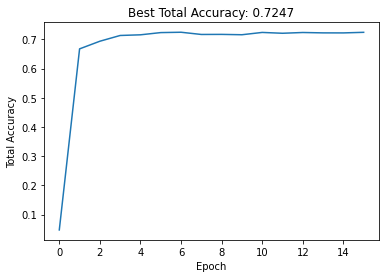

In [22]:
#plot raw accuracy
fig, ax = plt.subplots(1, 1)
ax.plot(accs)
ax.set_xlabel('Epoch')
ax.set_ylabel('Total Accuracy')
ax.set_title('Best Total Accuracy: ' + str(round(best_acc, 4)))

Text(0.5, 1.0, 'Best Class Average Accuracy: 0.5169, Best C.A. Precision: 0.5194')

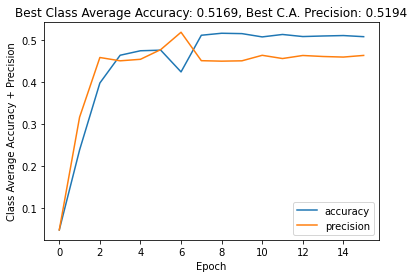

In [23]:
#plot class average accuracy
fig, ax = plt.subplots(1, 1)
ax.plot(class_avg_accs)
ax.plot(class_avg_precs)
ax.set_xlabel('Epoch')
ax.set_ylabel('Class Average Accuracy + Precision')
ax.legend(('accuracy', 'precision'))
ax.set_title('Best Class Average Accuracy: ' + str(round(best_classavg_acc, 4)) + ', Best C.A. Precision: ' + str(round(best_classavg_prec, 4)))

Text(0, 0.5, 'Class Precisions')

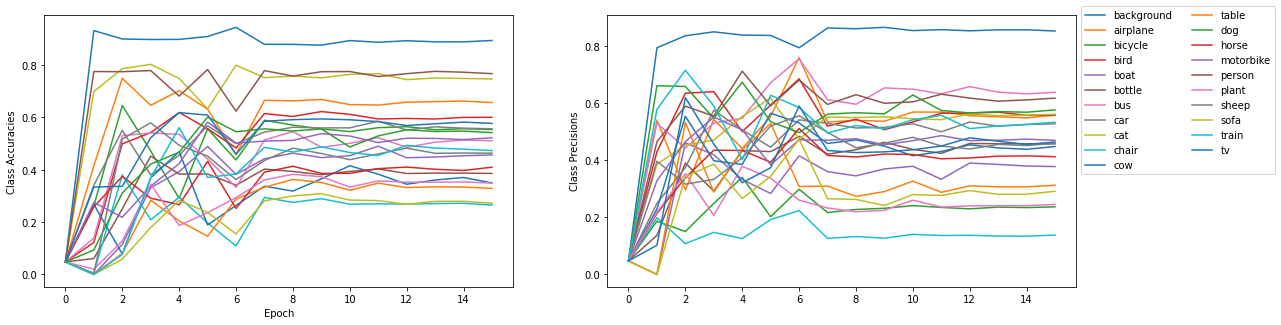

In [24]:
#plot class accuracies
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5)
ax1.plot(class_accs)
ax2.plot(class_precs)
ax2.legend(('background', 'airplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
           'car', 'cat', 'chair', 'cow', 'table', 'dog', 'horse', 'motorbike',
           'person', 'plant', 'sheep', 'sofa', 'train', 'tv'), bbox_to_anchor=(1, 1.05), ncol=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Class Accuracies')
ax2.set_ylabel('Class Precisions')

Text(0.5, 1.0, 'Training Loss on Every 20th Batch')

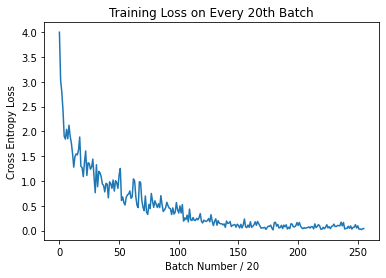

In [32]:
#plot training loss
fig, ax = plt.subplots(1, 1)
ax.plot(training_losses)
ax.set_xlabel('Batch Number / 20')
ax.set_ylabel('Cross Entropy Loss')
ax.set_title('Training Loss on Every 20th Batch')

In [25]:
print(class_avg_accs)
print(class_avg_precs)
print(accs)

[0.04761905 0.23844594 0.39822733 0.46447653 0.47516155 0.4765887
 0.42469656 0.51218432 0.51694053 0.51606655 0.50823498 0.51404244
 0.50908762 0.51042014 0.5114615  0.50876826]
[0.04761905 0.31661978 0.45909074 0.45118061 0.45478788 0.47795254
 0.51935607 0.45149058 0.45034409 0.45115393 0.46433169 0.45661798
 0.46389499 0.46146837 0.46011171 0.46404484]
[0.04761905 0.66778523 0.69396013 0.71365488 0.71593237 0.72353482
 0.72472697 0.71713364 0.7173847  0.71617877 0.72408378 0.72123456
 0.72384727 0.72256362 0.72245061 0.72446543]
